In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
from sklearn.model_selection import train_test_split
import umap
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from DataManager import DataManager

In [2]:
dm = DataManager()

In [3]:
dm.drug_df

,PlateName,Well,Content,compoundID_384,compoundID,mol.weight.Structure,Name,SecName,Class,Enzyme,Action,Selectivity,Description,GeneID,Selectivity_updated
0,P1,A03,sample,78875,78875,"195,22001",DL-alpha-Methyl-p-tyrosine,4-Hydroxy-alpha-methylphenylalanine,Neurotransmission,Enzyme,Inhibitor,Tyrosine hydroxylase,Inhibitor of catecholamine synthesis and tyros...,78875,Tyrosine hydroxylase
1,P1,A04,sample,78955,78955,"163,19638",N-Acetyl-L-Cysteine,,Glutamate,,Antagonist,,Amino acid analog that partially improves neur...,78955,AA-analog
2,P1,A05,sample,78876,78876,"202,25818","6-Methoxy-1,2,3,4-tetrahydro-9H-pyrido[3,4b] i...",,Neurotransmission,Enzyme,Inhibitor,MAO,MAO inhibitor,78876,MAO
3,P1,A06,sample,78956,78956,"131,17601",6-Aminohexanoic acid,6-Aminocaproic acid; EACA,Immune System,,Inhibitor,Blood Clotting,"Promotes rapid dissociation of plasmin, thereb...",78956,Blood Clotting
4,P1,A07,sample,78877,78877,"59,06825",Acetamide,Amide C2,Biochemistry,Enzyme,Inhibitor,Carbonic anhydrase,Carbonic anhydrase inhibitor,78877,Carbonic anhydrase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367,P4,P18,sample,80152,80152,"522,6251","( R)-(+)-WIN 55,212-2 mesylate","(R)-(+)-[2,3-Dihydro-5-methyl-3[(morpholinyl)m...",Cannabinoid,,Agonist,,High affinity cannabinoid receptor agonist,80152,NA
1368,P4,P19,sample,80073,80073,"423,34072","N,N,N-trimethyl-1-(4-trans-stilbenoxy)-2-propy...",F3,Cholinergic,,Antagonist,Nicotinic,Nicotinic acetylcholine receptor antagonist,80073,acetylcholine receptor
1369,P4,P20,sample,80153,80153,"428,49511",Xanthine amine congener,8-[4-[[[[(2-Aminoethyl)amino]carbonyl]methyl]o...,Adenosine,,Antagonist,A1,A1 Adenosine receptor antagonist,80153,adenosine receptor
1370,P4,P21,sample,80074,80074,"212,17589",1-[2-(Trifluoromethyl)phenyl]imidazole,TRIM,Nitric Oxide,Enzyme,Inhibitor,NOS,Potent nitric oxide synthase (NOS) inhibitor,80074,NOS


## Model

In [47]:
class PhenotypicFeaturesDataset(Dataset):
    def __init__(self, train=True, seed=42, train_val_split=0.15, transform=None):
        self.features_data = dm.data.values[:,3:]
        self.index_data = dm.data[["drug", "cell_line"]].values
        if train_val_split > 0:
            ftr_train, ftr_val, idx_train, idx_val = train_test_split(self.features_data, self.index_data, 
                                                                      test_size=train_val_split, 
                                                                      random_state=seed)
            self.features_data = ftr_train if train else ftr_val
            self.index_data = idx_train if train else idx_val
            
        if transform is not None:
            self.features_data = transform(self.features_data)

    def __len__(self):
        return len(self.features_data)

    def __getitem__(self, idx):
        return self.index_data[idx], self.features_data[idx]
    

class GMF(LightningModule):
    def __init__(self, hparams, train_dataset, val_dataset):
        super().__init__()
        self.hparams = hparams
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        
        output_size = hparams.get("output_size", 385)
        latent_dim = hparams.get("latent_dim", 10)
        dropout_p = hparams.get("dropout_p", 0.1)
        self.drug_embedding = nn.Embedding(len(np.unique(dm.data["drug"])), latent_dim)
        self.cl_embedding = nn.Embedding(len(np.unique(dm.data["cell_line"])), latent_dim)
        
        h_layers = hparams.get("h_layers", [63, 128])
        h_layers = [2*latent_dim] + h_layers
        act_function = hparams.get("activation", "ReLU")
        activation = getattr(nn, act_function)
        layers = []
        for i in range(len(h_layers)-1):
            layers.append(nn.Linear(h_layers[i], h_layers[i+1]))
            if act_function=="ReLU":
                layers.append(nn.Dropout(dropout_p))
                layers.append(activation())
            else:
                layers.append(activation())
                layers.append(nn.Dropout(dropout_p))
        layers.append(nn.Linear(h_layers[-1], output_size))
            
        self.network = nn.Sequential(*layers)
        
        loss_function = hparams.get("loss", "MSE")
        self.loss = None
        if loss_function == "MSE":
            self.loss = F.mse_loss
        elif loss_function == "L1":
            self.loss = F.l1_loss
        elif loss_function == "Huber":
            self.loss = nn.SmoothL1Loss()
        assert self.loss is not None
        
        
    def forward(self, drug, cell_line):
        drug_tensor = self.drug_embedding(drug)
        cell_line_tensor = self.cl_embedding(cell_line)
        input_tensor = torch.cat((drug_tensor, cell_line_tensor), dim=1)
        return self.network(input_tensor)
    
    def configure_optimizers(self):
        lr = self.hparams.get("lr", 1e-3)
        wd = self.hparams.get("wd", 1e-5)
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=lr,
                                     weight_decay=wd)
        return optimizer
    
    def train_dataloader(self):
        batch_size = self.hparams.get("batch_size", 32)
        num_workers = self.hparams.get("num_workers", 1)
        loader = DataLoader(self.train_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=True,
                            drop_last=False, pin_memory=True)
        return loader
    
    def val_dataloader(self):
        batch_size = self.hparams.get("batch_size", 32)
        num_workers = self.hparams.get("num_workers", 1)
        loader = DataLoader(self.val_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False,
                            drop_last=False, pin_memory=True)
        return loader
    
    def training_step(self, batch, batch_idx):
        indexing_tensor, features_tensor = batch
        
        drug_idxs_tensor = indexing_tensor[:,0]
        cl_idxs_tensor = indexing_tensor[:,1]
        output_tensor = self(drug_idxs_tensor, cl_idxs_tensor).double()
        train_loss = self.loss(output_tensor, features_tensor.double())
        
        
        return {"loss": train_loss}
    
    def validation_step(self, batch, batch_idx):
        indexing_tensor, features_tensor = batch
        
        drug_idxs_tensor = indexing_tensor[:,0]
        cl_idxs_tensor = indexing_tensor[:,1]
        output_tensor = self(drug_idxs_tensor, cl_idxs_tensor)
        val_loss = self.loss(output_tensor, features_tensor)
        outputs = {"loss": val_loss}
        return outputs

    def validation_epoch_end(self, outputs):
        if outputs:
            avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
            print("Validation Epoch Loss: {}".format(avg_loss))
            return {'val_loss': avg_loss}
        return {}
    
    def get_drug_embeddings(self):
        return self.drug_embedding.weight.cpu().detach().numpy()
    
    def get_cl_embeddings(self):
        return self.cl_embedding.weight.cpu().detach().numpy()

In [49]:
gmf_config = {"latent_dim": 2,
             "h_layers": [32, 64, 128],
             "activation": "ReLU",
             "lr": 1e-3,
             "wd": 1e-5,
             "batch_size": 32,
             "num_workers": 10,
              "loss": "MSE"
             }

train_ds = PhenotypicFeaturesDataset(train=True, seed=42, train_val_split=0.15, transform=None)
val_ds = PhenotypicFeaturesDataset(train=False, seed=42, train_val_split=0.15, transform=None)

model = GMF(gmf_config, train_ds, val_ds)

#early_stopping_cb = EarlyStopping('val_loss', patience=5)
trainer = Trainer(gpus=0,
                  max_epochs=5,
                  default_save_path="/home/gvisona/Projects/interpreting-representations/idr0017/output")
                  #logger=[tb_logger, neptune_logger],
                  #callbacks=[early_stopping_cb])
trainer.fit(model)

INFO:lightning:GPU available: False, used: False
INFO:lightning:
   | Name           | Type       | Params
------------------------------------------
0  | drug_embedding | Embedding  | 2 K   
1  | cl_embedding   | Embedding  | 24    
2  | network        | Sequential | 60 K  
3  | network.0      | Linear     | 160   
4  | network.1      | Dropout    | 0     
5  | network.2      | ReLU       | 0     
6  | network.3      | Linear     | 2 K   
7  | network.4      | Dropout    | 0     
8  | network.5      | ReLU       | 0     
9  | network.6      | Linear     | 8 K   
10 | network.7      | Dropout    | 0     
11 | network.8      | ReLU       | 0     
12 | network.9      | Linear     | 49 K  


Validation Epoch Loss: 31.399581317264836


Validation Epoch Loss: 0.10169445942492898


Validation Epoch Loss: 0.06201643497569682


Validation Epoch Loss: 0.054564353739761866


Validation Epoch Loss: 0.05020147383571859


Validation Epoch Loss: 0.05215585760052447



1

In [50]:
drug_embeddings = model.get_drug_embeddings()
cl_embeddings = model.get_cl_embeddings()

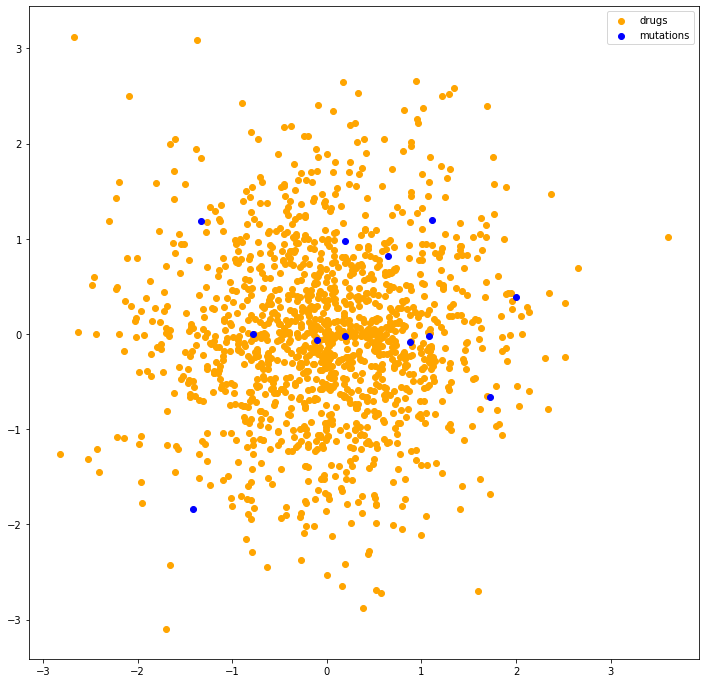

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(drug_embeddings[:,0], drug_embeddings[:,1], c="orange", label="drugs")
ax.scatter(cl_embeddings[:,0], cl_embeddings[:,1], c="blue", label="mutations")
ax.legend()
plt.show()

## Distances

In [54]:
from scipy.spatial import distance

def closest_node_sp(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

def closest_node_cos(node, nodes):
    closest_index = np.array([distance.cdist([node], [n]) for n in nodes]).argmin()
    return closest_index

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

In [58]:
dm.drug_df.iloc[1332]

PlateName                                                              P4
Well                                                                  O03
Content                                                            sample
compoundID_384                                                      79905
compoundID                                                          79905
mol.weight.Structure                                            427,03188
Name                    (+-)-threo-1-Phenyl-2-decanoylamino-3-morpholi...
SecName                                                PDMP hydrochloride
Class                                                        Sphingolipid
Enzyme                                                             Enzyme
Action                                                          Inhibitor
Selectivity                                     Glucosylceramide synthase
Description             Glucosylceramide synthase inhibitor; blocks fo...
GeneID                                

In [60]:
closest_embeddings = []
for cl in range(12):
    cl_name = dm.cell_line_df.iloc[cl]["mutationDetailed"]
    closest_drug_idx = closest_node(cl_embeddings[cl,:], drug_embeddings)
    drug_secname = dm.drug_df.iloc[closest_drug_idx]["SecName"]
    drug_name = dm.drug_df.iloc[closest_drug_idx]["Name"]
    closest_embeddings.append({"mutation_idx": cl, "mutation_name": cl_name,
                              "drug_idx": closest_drug_idx, "drug_secname": drug_secname,
                              "drug_name": drug_name})
ce_df = pd.DataFrame(closest_embeddings)
ce_df

,mutation_idx,mutation_name,drug_idx,drug_secname,drug_name
0,0,AKT1-/-&AKT2-/-,1332,PDMP hydrochloride,(+-)-threo-1-Phenyl-2-decanoylamino-3-morpholi...
1,1,MEK2-/-,261,,
2,2,AKT1-/-,1140,MDL-72222,"3-Tropanyl-3,5-dichlorobenzoate"
3,3,CTNNB1 mt-/wt+,877,,Methoxamine hydrochloride
4,4,PARENTAL007,875,"GI 267119X; 6-(2,3-dichlorophenyl)-1,2,4-triaz...",Lamotrigine
5,5,P53-/-,497,3-Hydroxy-5-aminomethylisoxazole hydrobromide,Muscimol hydrobromide
6,6,PTEN-/-,1073,Putrescine dihydrochloride,Putrescine dihydrochloride
7,7,PI3KCA mt-/wt+,103,4-Chlorobenzo[f]isoquinolone,CBIQ
8,8,KRAS mt-/wt+,933,"3-(2,4-Dichlorophenyl)-4-(1-methyl-1H-indol-3-...",SB 216763
9,9,BAX-/-,1324,"3,7-Dimethylxanthine",Theobromine


## Embedding + UMAP

In [61]:
gmf_config = {"latent_dim": 10,
             "h_layers": [32, 64, 128],
             "activation": "ReLU",
             "lr": 1e-3,
             "wd": 1e-5,
             "batch_size": 32,
             "num_workers": 10,
              "loss": "MSE"
             }

train_ds = PhenotypicFeaturesDataset(train=True, seed=42, train_val_split=0.15, transform=None)
val_ds = PhenotypicFeaturesDataset(train=False, seed=42, train_val_split=0.15, transform=None)

model2 = GMF(gmf_config, train_ds, val_ds)

#early_stopping_cb = EarlyStopping('val_loss', patience=5)
trainer = Trainer(gpus=0,
                  max_epochs=5,
                  default_save_path="/home/gvisona/Projects/interpreting-representations/idr0017/output")
                  #logger=[tb_logger, neptune_logger],
                  #callbacks=[early_stopping_cb])
trainer.fit(model2)

INFO:lightning:GPU available: False, used: False
INFO:lightning:
   | Name           | Type       | Params
------------------------------------------
0  | drug_embedding | Embedding  | 13 K  
1  | cl_embedding   | Embedding  | 120   
2  | network        | Sequential | 60 K  
3  | network.0      | Linear     | 672   
4  | network.1      | Dropout    | 0     
5  | network.2      | ReLU       | 0     
6  | network.3      | Linear     | 2 K   
7  | network.4      | Dropout    | 0     
8  | network.5      | ReLU       | 0     
9  | network.6      | Linear     | 8 K   
10 | network.7      | Dropout    | 0     
11 | network.8      | ReLU       | 0     
12 | network.9      | Linear     | 49 K  


Validation Epoch Loss: 31.396277484640287


Validation Epoch Loss: 0.07206748961761227


Validation Epoch Loss: 0.06038022428745045


Validation Epoch Loss: 0.053699895414743605


Validation Epoch Loss: 0.045605768070856145


Validation Epoch Loss: 0.04517822837820197



1

In [63]:
drug_embeddings2 = model.get_drug_embeddings()
cl_embeddings2 = model.get_cl_embeddings()

In [67]:
reducer = umap.UMAP(n_components=2, random_state=42)
drug_umap_embedding = reducer.fit_transform(drug_embeddings2)
cl_umap_embedding = reducer.transform(cl_embeddings2)

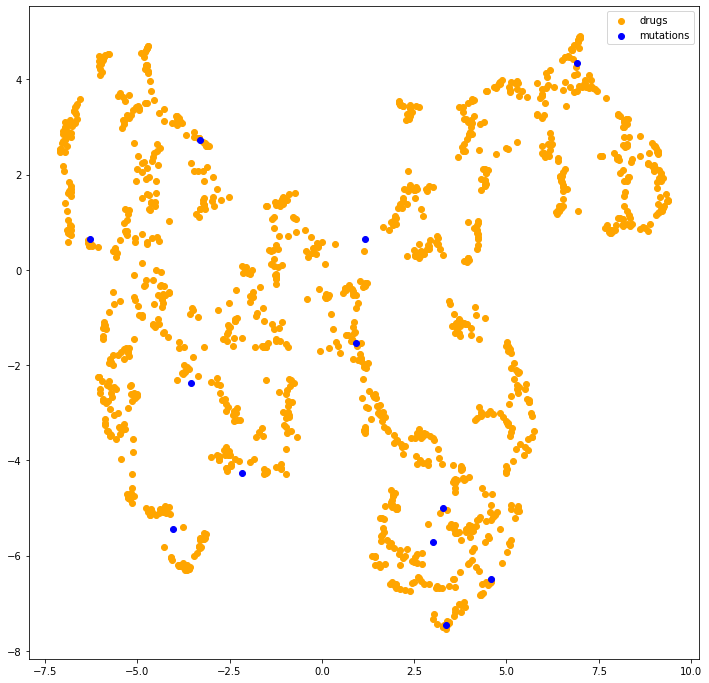

In [68]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(drug_umap_embedding[:,0], drug_umap_embedding[:,1], c="orange", label="drugs")
ax.scatter(cl_umap_embedding[:,0], cl_umap_embedding[:,1], c="blue", label="mutations")
ax.legend()
plt.show()